In [1]:


import json
import cv2 as cv
import pickle as pkl
from typing import Dict, List
import numpy as np
from matplotlib import pyplot as plt
import os, sys
import librosa

from scipy import stats, spatial, ndimage
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/Gaze_project')
sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/EvansToolBox/Utils")
sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/Gaze_project")
from Signal_processing_utils import intensity_from_signal, pitch_from_signal, sparse_key_smoothing, laplacian_smoothing
from Speech_Data_util import Sentence_word_phone_parser
from prototypes.InputDataStructures import Dietic_Conversation_Gaze_Scene_Info
from prototypes.MVP.MVP_static_saliency_list import ObjectBasedFixSaliency
from prototypes.MVP.MVP_Aversion_saliency_list import AversionSignalDrivenSaliency, CTSAversionSignalDrivenSaliency
from prototypes.MVP.MVP_look_at_point_planner import HabituationBasedPlanner, RandomPlanner, PartnerHabituationPlanner
from prototypes.MVP.MVP_eye_head_driver import HeuristicGazeMotionGenerator
from prototypes.MVP.MVP_Aversion_saliency_list import Base_Static_Saliency_List
from prototypes.EyeCatch.Saccade_model_with_internal_model import *
from prototypes.Gaze_aversion_prior.Heuristic_model import *
from prototypes.Boccignone2020.Gaze_target_planner import Scavenger_based_planner
from prototypes.Boccignone2020.Improved_gaze_target_planner import Scavenger_planner_with_nest, Scavenger_planner_simple 
from prototypes.JaliNeck.JaliNeck import NeckCurve
from prototypes.Gaze_aversion_prior.Ribhav_model import predict_aversion
from prototypes.InputDataStructures import AgentInfo, TurnTakingData
from prototypes.MVP.MVP_gaze_path_planner import Responsive_planner_simple
import pickle
import math
from datetime import datetime, timezone
import scipy.stats as ss
from Signal_processing_utils import interpolate1D
import numpy as np
from scipy.interpolate import interp1d



In [2]:
%load_ext autoreload
%autoreload 1

%aimport prototypes.InputDataStructures
%aimport Speech_Data_util
%aimport prototypes.MVP.MVP_static_saliency_list
%aimport prototypes.EyeCatch.Saccade_model_with_internal_model
%aimport prototypes.InputDataStructures
%aimport prototypes.Jin2019.EyeHeadDecomposition
%aimport prototypes.Optimization_based_head_eye_seperator.Baseline_optimization
%aimport prototypes.Boccignone2020.Improved_gaze_target_planner
%aimport prototypes.MVP.MVP_gaze_path_planner
%aimport prototypes.JaliNeck.JaliNeck


In [3]:
# inputs
input_folder = "/Volumes/EVAN_DISK/MASC/Ribhav_processed_dataset/"
# input_folder = "F:/MASC/Ribhav_processed_dataset/"
# input_file = "Stranger Things’ Dacre Montgomery’s Insane _Billy_ Audition Tape ｜ GQ"
input_file = "Madelaine Petsch audition for The Prom"
shot_id = 1
speaker_id = 1
turn_taking_threshold = 2
fps = 24
np.random.seed(speaker_id + shot_id)


### Gather The transcript and Audio From Jali (because it's more reliable)

In [4]:

input_file_no_space = "_".join(input_file.split(" "))
# input_file_no_space = "'" + input_file_no_space + "'"
shot_file_name = os.path.join(os.path.join(os.path.join(input_folder, "shots"), input_file), "shot_cuts.json")
video_path = os.path.join(*[input_folder, "video", input_file+".mp4"])
audio_1_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}.wav".format(shot_id, 1))
audio_2_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}.wav".format(shot_id, 2))
script_1_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}.txt".format(shot_id, 1))
script_2_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}.txt".format(shot_id, 2))
praatoutput_1_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}_PraatOutput.txt".format(shot_id, 1))
praatoutput_2_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}_PraatOutput.txt".format(shot_id, 2))
head_direction_json_path = os.path.join(*[input_folder, "pose", input_file+".pkl"])
output_location = os.path.join(*[input_folder, "outputs", input_file+".pkl"])
output_gaze_deploy_location = os.path.join(*[input_folder, "outputs", input_file+"_gaze_deploy.pkl"])
output_static_salience_location = os.path.join(*[input_folder, "outputs", input_file+"_static_salience_map.pkl"])
output_stare_location = os.path.join(*[input_folder, "outputs", input_file+"_stare.pkl"])

scene_data_path = os.path.join(*[input_folder, "annotated_scene", input_file+".json"])
# output_location = "/Users/evanpan/Documents/GitHub/Gaze_project/data/look_at_points/prototype2p2.pkl"
# output_location = "C:/Users/evansamaa/Documents/GitHub/Gaze_project/data/look_at_points/prototype2p2.pkl"

sementic_script_1 = Sentence_word_phone_parser(praatoutput_1_path, script_1_path)
# sementic_script_1.get_turns(turn_taking_threshold)
sementic_script_2 = Sentence_word_phone_parser(praatoutput_2_path, script_2_path)
# sementic_script_2.get_turns(turn_taking_threshold)
audio_1, sr= librosa.load(audio_1_path, sr=44100)
audio_2, sr= librosa.load(audio_2_path, sr=44100)
agentScene1 = AgentInfo(scene_data_path, wonder=False)
agentScene2 = AgentInfo(scene_data_path, wonder=False)

### Compute Turn Taking Gaze Behaviour for character 1

In [5]:
def find_index(lst, t):
    left, right = 0, len(lst) - 1
    while left <= right:
        mid = (left + right) // 2
        if lst[mid][0] <= t and lst[mid][1] >= t:
            return mid
        elif lst[mid][1] < t:
            left = mid + 1
        elif lst[mid][0] > t:
            right = mid - 1
    return -1
def find_closest_next(lst, t):
    left, right = 0, len(lst) - 1
    closest_index = None
    
    while left <= right:
        mid = (left + right) // 2
        if closest_index is None or abs(lst[mid][0] - t) < abs(lst[closest_index][0] - t):
            closest_index = mid
        
        if lst[mid][0] <= t:
            left = mid + 1
        else:
            right = mid - 1
    
    return closest_index
def find_closest_prev(lst, t):
    left, right = 0, len(lst) - 1
    closest_index = None
    
    while left <= right:
        mid = (left + right) // 2
        if closest_index is None or abs(lst[mid][1] - t) <= abs(lst[closest_index][1] - t):
            closest_index = mid
        
        if lst[mid][1] <= t:
            left = mid + 1
        else:
            right = mid - 1
    
    return closest_index

In [6]:
prob_direct_gaze = np.array([0.00078064, 0.00078064, 0.00078064, 0.        , 0.00078064,
0.00078064, 0.00156128, 0.00156128, 0.00156128, 0.        ,
       0.00078064, 0.00156128, 0.00078064, 0.00234192, 0.00468384,
       0.0039032 , 0.00624512, 0.00858704, 0.0039032 , 0.01092896,
       0.02185792, 0.04996097, 0.13739266, 0.45199063, 0.12880562,
       0.07416081, 0.03278689, 0.01249024, 0.01092896, 0.00702576,
       0.00546448, 0.00234192, 0.00156128, 0.0039032 , 0.00156128,
       0.00078064, 0.00156128, 0.        , 0.00078064, 0.00234192])
delay_of_direct_gaze = np.array([-48.2  , -46.178, -44.156, -42.134, -40.112, -38.09 , -36.068,
       -34.046, -32.024, -30.002, -27.98 , -25.958, -23.936, -21.914,
       -19.892, -17.87 , -15.848, -13.826, -11.804,  -9.782,  -7.76 ,
        -5.738,  -3.716,  -1.694,   0.328,   2.35 ,   4.372,   6.394,
         8.416,  10.438,  12.46 ,  14.482,  16.504,  18.526,  20.548,
        22.57 ,  24.592,  26.614,  28.636,  30.658,  32.68 ])
prov_direct_gaze = ss.rv_histogram([prob_direct_gaze, delay_of_direct_gaze])

In [7]:
if speaker_id == 1:
    self_script = sementic_script_1
    other_script = sementic_script_2
    scene = agentScene1
    audio = audio_1
    audio_location = audio_1_path
else:
    other_script = sementic_script_1
    self_script = sementic_script_2
    audio = audio_2
    scene = agentScene2
    audio_location = audio_2_path
turn_taking_salience_list = []
turn_taking_inhibition_list = []
# compute
t_end = max(self_script.phone_intervals[-1][1], other_script.phone_intervals[-1][1]) + 5
t_end_frame = math.floor(t_end * fps)
ts = np.arange(0, t_end_frame)/fps
out = []
skip=False
prev_salience = 0
prev_inhibition = 0
for t in ts:
    # if current turn is skipped, simply repeat the previous salience
    self_interval_index = find_index(self_script.turns_intervals, t)
    other_interval_index = find_index(other_script.turns_intervals, t)
    if skip:
        turn_taking_salience_list += [prev_salience]
        turn_taking_inhibition_list += [prev_inhibition] 
        if other_interval_index >= 0 and t > (other_script.turns_intervals[other_interval_index][1] + other_script.turns_intervals[other_interval_index][0])/2:
            skip = False
    elif other_interval_index >= 0:
        # if the other person is talking, the influence from turn taking is to look at them
        turn_taking_salience_list += [1]
        turn_taking_inhibition_list += [1] # this one is multiplicative
    elif self_interval_index >= 0:
        interval = self_script.turns_intervals[self_interval_index]
        # if the speech is an interjection:
        prev_partner_speech_interval = other_script.turns_intervals[find_closest_prev(other_script.turns_intervals, t)]
        next_partner_speech_interval = other_script.turns_intervals[find_closest_next(other_script.turns_intervals, t)]
        if next_partner_speech_interval[0] - prev_partner_speech_interval[1] < 2: # i.e. very close to the current
            turn_taking_salience_list += [1]
            turn_taking_inhibition_list += [1] # this one is multiplicative
        else:
            # otherwise try and see 
            delay = prov_direct_gaze.rvs(1)
            if interval[1] - t + delay < 0:
                skip=True
                turn_taking_salience_list += [1]
                turn_taking_inhibition_list += [1] # this one is multiplicative
            else:        
                turn_taking_salience_list += [0]
                turn_taking_inhibition_list += [1] # this one is multiplicative  
    else:     
        turn_taking_salience_list += [0]
        turn_taking_inhibition_list += [1] # this one is multiplicative
turn_taking_salience_list = np.array(turn_taking_salience_list)
turn_taking_inhibition_list = np.array(turn_taking_inhibition_list)

In [8]:
class TurnTakingDrivenSaliency(Base_Static_Saliency_List):
    def __init__(self, scene_info: AgentInfo, audio: np.array, script: Sentence_word_phone_parser, sr=44100, dt=1/24):
        self.scene_info: AgentInfo = scene_info
        self._number_of_objects = scene_info.get_all_positions().shape[0]
        self._sr = sr
        self._dt = dt # 100 hz
        self._audio_start = 0
        self._audio_end = float(audio.shape[0]) / float(self._sr)
        self._numb_of_frames = int(np.ceil((self._audio_end) / self._dt)) # total number of frames
        # self._audio = audio
        # self._script = script
        self.evaluated = False
        self.map = np.zeros((int(self._numb_of_frames), self._number_of_objects))
        self.map_interp = None
    def get_object_positions(self):
        return self.scene_info.get_all_positions()
    
    def evaluate_all(self):
        if self.evaluated:
            return self.map
        else:
            self.compute_salience()
            x = np.arange(0, self._numb_of_frames) * self._dt
            self.map_interp = interp1d(x, self.map, axis=0, fill_value="extrapolate")
            self.evaluated = True
            return self.map
    def evaluate(self, t):
        if self.evaluated:
            return self.map_interp(t)
        else:
            self.compute_salience()
            x = np.arange(0, self._numb_of_frames) * self._dt
            self.map_interp = interp1d(x, self.map, axis=0, fill_value="extrapolate")
            self.evaluated = True
            return self.map_interp(t)
    def compute_salience(self, aversion_prob_time, aversion_prob_val, interval=True):
        # continue setting salience for all objects
        for j in range(0, self._numb_of_frames):
            for i in range(0, self._number_of_objects):
                if i < self.scene_info.get_object_positions(coordinate_space="global").shape[0]:
                    self.map[j, i] = self.scene_info.object_interest[i]
                elif i == self.scene_info.get_object_positions(coordinate_space="global").shape[0]:
                    self.map[j, i] = 1 - interpolate1D(aversion_prob_time, aversion_prob_val, float(j) * self._dt)                
                else:
                    if interpolate1D(aversion_prob_time, aversion_prob_val, float(j) * self._dt) < 0.3:
                        self.map[j, i] = 0
                    else:
                        self.map[j, i] = 0.5

aversion_saliency = TurnTakingDrivenSaliency(scene, audio, None, dt=0.02)
aversion_saliency.compute_salience(ts, turn_taking_salience_list)
static_aversion_saliency = ObjectBasedFixSaliency(scene, audio, None, sr = sr)
static_aversion_saliency.compute_salience()



In [9]:
from prototypes.MVP.MVP_static_saliency_list import ObjectBasedFixSaliency
from prototypes.MVP.MVP_Aversion_saliency_list import AversionSignalDrivenSaliency
from Geometry_Util import rotation_angles_frome_positions
import numpy as np
from matplotlib import pyplot as plt
class Scavenger_planner_simple:
    def __init__(self, saliency_maps, scene_info, self_id=-1):
        # hyper-parameters
        self.smoothing_constant = 0.2
        self.kappa = 1.333333 # this is the distance factor (i.e. cost of migration), this is from the paper
        self.kappa = 2.2 # this is the distance factor (i.e. cost of migration)
        self.momentum_weight = 3
        self.phi = .5 # this is the consumption efficiency i.e. how long it takes to consume all resources within a patch
        self.beta = 20 # this is use to generate the probability of the bernoulli variable that determines staying vs
        self.min_saccade_time = 0.4 # this specified how closely two nearby saccade can be with one another.

        self.nest_consumption_rate = 0.05 # the amount of time to consume food at the nest
        # TODO: this tao should also be time varying (Using this for the basis to implement reactive gaze (to the
        # listener's gaze))
        self.predation_risk_tao = 0.5 # the constant for exponential distribution for predation
        # get the dt
        self.dt = saliency_maps[0]._dt
        # ====================================== Storing saliency maps ======================================
        # store information about the scene
        self.scene_info = scene_info
        # store the saliency maps as a list of array, make sure they all have the same length
        self.saliency_maps_arrs = []
        # similarly store all the positions
        self.object_positions = []
        # get the maximum size
        self.self_id = self_id
        object_count = 0
        time_count = 0
        max_id = 0
        for i in range(0, len(saliency_maps)):
            arr = saliency_maps[i].map
            if arr.shape[1] > object_count:
                object_count = arr.shape[1]
                max_id = i
            if arr.shape[0] > time_count:
                time_count = arr.shape[0]
        for i in range(0, len(saliency_maps)):
            arr = saliency_maps[i].map
            if arr.shape[1] < object_count:
                extension = np.zeros((arr.shape[0], object_count-arr.shape[1]))
                arr = np.concatenate([arr, extension], axis=1)
            if arr.shape[0] < time_count:
                extension = np.zeros((time_count - arr.shape[0], object_count))
                arr = np.concatenate([arr, extension], axis=0)
            self.saliency_maps_arrs.append(arr)
        # get the position of objects
        self.object_positions = saliency_maps[max_id].get_object_positions()
        # turn them into rotation angles
        self.object_positions = rotation_angles_frome_positions(self.object_positions) / 180 * np.pi
        # get the conversation partner's id
        if self.self_id == -1:
            self.conversation_partner_id = agentScene1.object_pos.shape[0]
            # ========================================= state variables ==========================================
            self.current_look_at = self.conversation_partner_id
            # index for the nest, of which the gaze will gravitate towards
            self.nest_index = self.conversation_partner_id
        else:
            self.conversation_partner_id = agentScene1.object_pos.shape[0]
            # ========================================= state variables ==========================================
            self.current_look_at = self.conversation_partner_id
            # index for the nest, of which the gaze will gravitate towards
            self.nest_index = self.conversation_partner_id
        # momentum stores the current gaze_direction from the conversation-partner
        self.momentum = np.array([0, 0])
    def compute(self, initial_target):
        # variable to store the output values
        output_t = [0]
        output_target = [self.nest_index]
        # step 1: obtain smoothed saliency map
        for i in range(0, len(self.saliency_maps_arrs)):
            map_i = self.saliency_maps_arrs[i]
            smoothed_map = np.zeros(self.saliency_maps_arrs[i].shape)
            for t in range(0, map_i.shape[0]):
                smoothed_map[t] = map_i[max(0, t-1)] * self.smoothing_constant + (1 - self.smoothing_constant) * map_i[t]
            self.saliency_maps_arrs[i] = smoothed_map
        # step 2: obtain patches through thresholding, we skip this step as we don't work with images, but a list of objects
        # step 3: perform the planning
        # perform a summation for all saliency maps to obtain the overall resources:
        values = np.zeros(self.saliency_maps_arrs[0].shape)
        for map_arr in self.saliency_maps_arrs:
            values += map_arr
        if self.self_id >= 0:
            values[:, self.self_id] = 0
        # initialize the first look at point with the user speficied initial target
        self.current_look_at = self.nest_index
        time_within_patch = 0
        time_away_from_nest = 0
        # add the first target to the output list
        output_target.append(self.current_look_at)
        output_t.append(0)
        for i in range(0, self.saliency_maps_arrs[0].shape[0]):
            # update new nest
            if self.self_id >= 0:
                self.nest_index = agentScene1.object_pos.shape[0]
            ##############################################################################################
            ############################### decide whether to switch patch ###############################
            ##############################################################################################
            # compute rho (value)
            look_at_mask = np.zeros((self.saliency_maps_arrs[0].shape[1], ))
            look_at_mask[self.current_look_at] = 1
            not_looked_at_mask = np.ones(look_at_mask.shape) - look_at_mask
            # compute the distance to the patch (first use this variable to store the position of look_at_point)
            distance_to_patch = np.tile(self.object_positions[self.current_look_at:self.current_look_at+1], [self.object_positions.shape[0], 1])
            distance_to_patch = (distance_to_patch - self.object_positions)
            distance_to_patch = np.sqrt(np.square(distance_to_patch).sum(axis=1))

            # compute the distance to the nest
            distance_to_nest = np.tile(self.object_positions[self.nest_index:self.nest_index + 1], [self.object_positions.shape[0], 1])
            distance_to_nest = (distance_to_nest - self.object_positions)
            distance_to_nest = np.sqrt(np.square(distance_to_nest).sum(axis=1))
            # updates 5 times a second
            if (float(i) * self.dt / 0.1).is_integer() and i > 0:
                # if we are currently in the nest
                if self.current_look_at == self.nest_index :
                    # compute the average value of going out
                    M = self.nest_consumption_rate
                    rho = values[i] * np.exp(-self.kappa * distance_to_patch)
                    rho[self.current_look_at] = rho[self.current_look_at] * np.exp(-self.nest_consumption_rate * time_within_patch)
                    rho_mean = 1 / (rho.shape[0] - 1) * np.sum(rho * not_looked_at_mask)
                    rho_max = np.max(rho * not_looked_at_mask)
                    p_leave = 1 / (1 + np.exp(self.beta * (rho[self.current_look_at] - rho_mean)))
                    rv = np.random.binomial(1, p_leave)
                    if rv == 1:
                        prob = values[i] * np.exp(-self.kappa * distance_to_patch) * not_looked_at_mask
                        heat = self.beta/2
                        probability = np.exp(heat * prob)/np.sum(np.exp(heat * prob))
                        probability[self.self_id] = 0
                        probability = probability / probability.sum()
                        # find the item with maximum probability
                        deterministic_new_patch = np.argmax(prob)
                        # sample the items for a more randomized new look-at-point
                        sampled_new_patch = np.random.choice(np.arange(0, prob.shape[0]), 1, p=probability)[0]
                        # use the sampled patch id for better looking result in a static scene
                        new_patch = sampled_new_patch
                        time_within_patch = 0
                        time_away_from_nest = 0
                        self.current_look_at = new_patch
                        output_target.append(self.current_look_at)
                        output_t.append(self.dt * i)
                        self.momentum = self.object_positions[self.current_look_at] - self.object_positions[self.nest_index]
                else:

                    # compute distance-weighted patch value rho
                    momemtum_distance = np.expand_dims(self.momentum, axis=0)
                    momemtum_distance = momemtum_distance * (self.object_positions - np.expand_dims(self.object_positions[self.nest_index], axis=0))
                    momemtum_distance = 1 / (1 + np.exp(- 10 * momemtum_distance.sum(axis=1)))
                    rho = values[i] * np.exp(-self.kappa * distance_to_patch)
                    risk = np.exp(-self.kappa * distance_to_nest) * self.predation_risk_tao * np.exp(self.predation_risk_tao * time_away_from_nest)
                    # if it is still worth it to not return to nest
                    if (rho - risk).max() > 0:
                        # compute Q, the expected return of leaving the current patch and move to another patch
                        Q = 1 / (self.object_positions.shape[0] - 1) * np.sum(rho * not_looked_at_mask * np.exp(-momemtum_distance))
                        # compute g_patch, the instetaneous gain by staying at the current patch
                        if rho[self.current_look_at] > 0:
                            g_patch = rho[self.current_look_at]
                            g_patch = rho[self.current_look_at] * np.exp(-self.phi / values[i, self.current_look_at] * time_within_patch)
                        else:
                            g_patch = 0
                        # compute the probability of migration (logistic function as per the paper, howeverm it is very noisy )
                        p_stay = 1 / (1 + np.exp(-self.beta*(g_patch - Q)))
                        ########################### sample from bernoulli distribution to determine wheter to switch patch #####################
                        # if the sampling determine that there is a patch switch (the issue is that given the sampling frequency,
                        # it is actually highly likely for the gaze target to switch
                        if p_stay <= 1.0:
                            rv = np.random.binomial(1, p_stay)
                        else:
                            rv = 0
                        if rv == 0 and time_within_patch >= self.min_saccade_time:
                            # get probability of the gaze aversion
                            prob = values[i] * np.exp(-self.kappa * distance_to_patch) * not_looked_at_mask * np.exp(-self.momentum_weight*momemtum_distance)
                            heat = self.beta / 2
                            probability = np.exp(heat * prob) / np.sum(np.exp(heat * prob))
                            probability[self.self_id] = 0
                            probability = probability / probability.sum()
                            # find the item with maximum probability
                            deterministic_new_patch = np.argmax(prob)
                            # sample the items for a more randomized new look-at-point
                            sampled_new_patch = np.random.choice(np.arange(0, prob.shape[0]), 1, p=probability)[0]
                            # use the sampled patch id for better looking result in a static scene
                            new_patch = sampled_new_patch

                            time_within_patch = 0
                            self.current_look_at = new_patch
                            output_target.append(self.current_look_at)
                            output_t.append(self.dt * i)
                            self.momentum = self.object_positions[self.current_look_at] - self.object_positions[self.nest_index]
                    else:
                        time_within_patch = 0
                        time_away_from_nest = 0
                        self.current_look_at = self.nest_index
                        output_target.append(self.current_look_at)
                        output_t.append(self.dt * i)
                        self.momentum = self.momentum * 0

            # accumulate time away and within patch
            time_within_patch += self.dt
            time_away_from_nest += self.dt
        output_t.append(self.dt * values.shape[0])
        output_target.append(self.conversation_partner_id)
        return output_t, output_target
    def model_fitting(self, average_aversion_duration, average_gaze_duration):
        return
# planner = Scavenger_planner_simple([aversion_saliency], scene)
# planner = Scavenger_planner_with_nest([base_saliency, aversion_saliency], scene)
# output_times, output_targets = planner.compute(scene.object_pos.shape[0])

In [10]:
planner = Responsive_planner_simple([aversion_saliency], scene)
output_times, output_targets = planner.compute()
# plt.plot(output_times, output_targets)

In [11]:
# =============================================================================================
# ========================== plan scan path based on the saliency maps ========================
# =============================================================================================
# get view_target planner
# planner = PartnerHabituationPlanner(base_saliency, audio, sementic_script, scene, 0.8)
# planner = HabituationBasedPlanner(base_saliency, audio, sementic_script, scene, 0.7)
# compute the gaze targets and times
# output_times, output_targets = planner.compute()
#get the output_targets_positions from the scene
output_target_positions = []
for i in output_targets:
    output_target_positions.append(scene.get_all_positions(coordinate_space="local", index=i))
internal_model = InternalModelCenterBias(scene)
# the good model
generator = SacccadeGenerator(output_times, output_target_positions, output_targets, internal_model)
# print(output_times, output_target_positions, output_targets)
ek, hk, micro_saccade = generator.compute()
conversational_neck = NeckCurve(audio_location)
jali_neck_output = conversational_neck.compute_curve()

blend_weight = []
for i in range(1, len(hk[0])-1): 
    velocity = math.sqrt((hk[0][i][1]-hk[0][i-1][1])**2 + (hk[0][i-1][2]-hk[0][i][2])**2)
    blend_weight.append([hk[0][i][0], 1 - min(1, velocity/0.75)])
# motion_generator = HeuristicGazeMotionGenerator(scene, sementic_script)
# ek, hk, micro_saccade = motion_generator.generate_neck_eye_curve(output_times, output_target_positions)
# output_location = "C:/Users/evan1/Documents/Gaze_project/data/look_at_points/prototype2p2.pkl"
# output_location = "C:/Users/evansamaa/Documents/GitHub/Gaze_project/data/look_at_points/prototype2p2.pkl"
# output_location = "/Users/evanpan/Documents/GitHub/Gaze_project/data/look_at_points/prototype2p2.pkl"
out = {"eye_frames": ek,
        "head_frames": hk,
        "micro_saccade": micro_saccade,
        "other_neck": jali_neck_output,
        "envelope":[]}
        # "output_times": output_times, 
        # "output_targets": output_targets}
pickle.dump(out, open(output_location, 'wb'), protocol=2)
print(output_location)

31 (31, 2)
41
41
/Volumes/EVAN_DISK/MASC/Ribhav_processed_dataset/outputs/Madelaine Petsch audition for The Prom.pkl


# generate motion from the lesser models

In [12]:
internal_model = InternalModelCenterBias(scene)
conversational_neck = NeckCurve(audio_location)
jali_neck_output = conversational_neck.compute_curve()
blend_weight = []

# other models -> gaze deploy model
planner = Scavenger_planner_simple([aversion_saliency], scene)
gaze_deploy_output_times, gaze_deploy_output_targets = planner.compute(scene.object_pos.shape[0])
gaze_deploy_output_target_positions = []
for i in gaze_deploy_output_targets:
    gaze_deploy_output_target_positions.append(scene.get_all_positions(coordinate_space="local", index=i))
gp_generator = SacccadeGenerator(gaze_deploy_output_times, gaze_deploy_output_target_positions, gaze_deploy_output_targets, internal_model)
gp_ek, gp_hk, gp_micro_saccade = gp_generator.compute()
out = {"eye_frames": gp_ek,
       "head_frames": gp_hk,
       "micro_saccade": gp_micro_saccade,
       "other_neck": jali_neck_output,
       "envelope":[],}
pickle.dump(out, open(output_gaze_deploy_location, 'wb'), protocol=2)
print(output_gaze_deploy_location)

# other models -> but static salience
planner = Scavenger_planner_simple([static_aversion_saliency], scene)
static_output_times, static_output_targets = planner.compute(scene.object_pos.shape[0])
static_output_target_positions = []
for i in static_output_targets:
    static_output_target_positions.append(scene.get_all_positions(coordinate_space="local", index=i))
s_generator = SacccadeGenerator(static_output_times, static_output_target_positions, static_output_targets, internal_model)
s_ek, s_hk, s_micro_saccade = s_generator.compute()
out = {"eye_frames": s_ek,
       "head_frames": s_hk,
       "micro_saccade": s_micro_saccade,
       "other_neck": jali_neck_output,
       "envelope":[],
       "output_times": static_output_times, 
       "output_targets": static_output_targets}
pickle.dump(out, open(output_static_salience_location, 'wb'), protocol=2)
print(output_static_salience_location)

# just stare
stare_output_times = [static_output_times[0], static_output_times[-1]]
stare_output_targets = [scene.object_pos.shape[0], scene.object_pos.shape[0]]
stare_output_target_positions = []
for i in stare_output_targets:
    stare_output_target_positions.append(scene.get_all_positions(coordinate_space="local", index=i))
s_generator = SacccadeGenerator(stare_output_times, stare_output_target_positions, stare_output_targets, internal_model)
s_ek, s_hk, s_micro_saccade = s_generator.compute()
out = {"eye_frames": s_ek,
       "head_frames": s_hk,
       "micro_saccade": s_micro_saccade,
       "other_neck": jali_neck_output,
       "envelope":[],
       "output_times": stare_output_times, 
       "output_targets": stare_output_targets}
pickle.dump(out, open(output_stare_location, 'wb'), protocol=2)
print(output_stare_location)

41
41
367 (367, 2)
/Volumes/EVAN_DISK/MASC/Ribhav_processed_dataset/outputs/Madelaine Petsch audition for The Prom_gaze_deploy.pkl
9 (9, 2)
/Volumes/EVAN_DISK/MASC/Ribhav_processed_dataset/outputs/Madelaine Petsch audition for The Prom_static_salience_map.pkl
1 (1, 2)
/Volumes/EVAN_DISK/MASC/Ribhav_processed_dataset/outputs/Madelaine Petsch audition for The Prom_stare.pkl


# Load with real noise

In [82]:
# only use opencv to get fps from video
vid = cv.VideoCapture(video_path)
fps = vid.get(cv.CAP_PROP_FPS)
# delay (how the actual audio was cut)
delay = 120 + 33 + .4 # the audio started at this point of the video
delay_in_frames = int(np.floor(delay * fps))

all_head_data = pkl.load(open(head_direction_json_path, "rb"))
head_angle_data = all_head_data["HEAD"]
head_rotmat_per_frame = head_angle_data["ROTMAT"]
head_euler_per_frame = head_angle_data["EULER"]
head_angle_per_frame = []
neutral_position = np.array([0, 0, 100])
for i in range(0, head_rotmat_per_frame.shape[0]):
    pos = head_rotmat_per_frame[i] @ neutral_position
    head_angle_per_frame.append(rotation_angles_frome_positions(pos[:]))
neutral_position2 = np.array([0, 100, 0])
head_angle_z_per_frame = []
for i in range(0, head_rotmat_per_frame.shape[0]):
    pos = head_rotmat_per_frame[i] @ neutral_position2
    pos = np.array([pos[1], pos[2], pos[0]])
    
    head_angle_z_per_frame.append(rotation_angles_frome_positions(pos)[1])
# get all three direction
head_angle_per_frame = np.array(head_angle_per_frame)
head_angle_z_per_frame = np.array(head_angle_z_per_frame)
head_angle_z_per_frame = np.expand_dims(head_angle_z_per_frame, axis=1)
head_angle_per_frame = np.concatenate([head_angle_per_frame, head_angle_z_per_frame], axis=1)

# export the head_angles
ts = np.arange(0, head_angle_per_frame.shape[0]) / fps - delay
ts = ts.tolist()
raw_out_head = []
delta_out_head = []
for i in range(3):
    delta = head_angle_per_frame[:, i] - ndimage.gaussian_filter1d(head_angle_per_frame[:, i] , sigma=10)
    delta = ndimage.gaussian_filter1d(delta, sigma=5).tolist()
    head_dir_i = ndimage.gaussian_filter1d(head_angle_per_frame[:, i], sigma=5).tolist()
    plt.plot(head_angle_per_frame[:, i],  label="raw signal")
    plt.plot(ndimage.gaussian_filter1d(head_angle_per_frame[:, i] , sigma=10), label="smoothed signal")
    plt.legend()
    plt.show()
    raw_out_head = raw_out_head + [ts[delay_in_frames:], head_dir_i[delay_in_frames:]]
    delta_out_head = delta_out_head + [ts[delay_in_frames:], delta[delay_in_frames:]]
# out = [ek, hk, micro_saccade, delta_out_head, []]
out = {"eye_frames": ek,
       "head_frames": hk,
       "micro_saccade": micro_saccade,
       "other_neck": delta_out_head,
       "envelope":[]}
pickle.dump(out, open(output_location, 'wb'), protocol=2)
print("done")

ModuleNotFoundError: No module named 'scipy.spatial.transform._rotation'

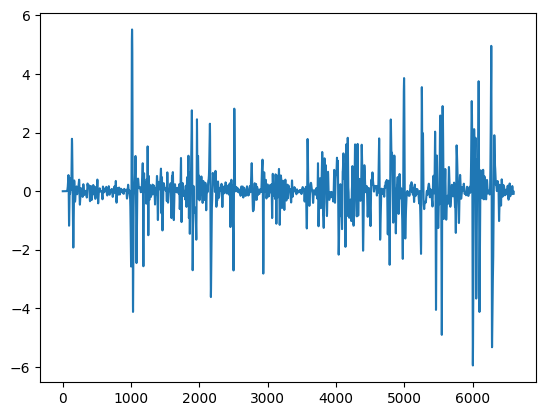

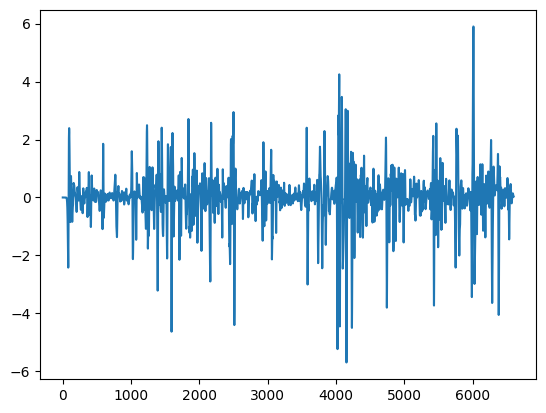

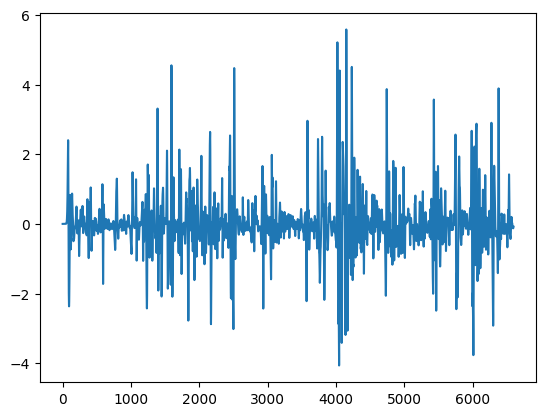

In [70]:
for i in range(3):
    delta = head_angle_per_frame[:, i] - ndimage.gaussian_filter1d(head_angle_per_frame[:, i] , sigma=10)
    delta = ndimage.gaussian_filter1d(delta , sigma=3)
    plt.plot(delta)
    plt.show()

# check internal model

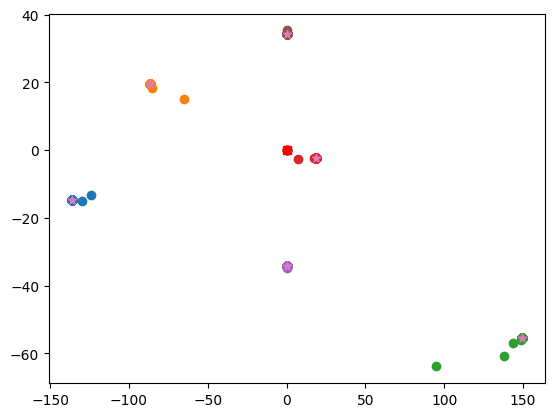

In [187]:

for i in range(0, 6):
    start = np.array([0, 0, 100])
    total = [start]
    for j in range(0, 100):
        start = internal_model.estimate_target_pose(i, start)
        total.append(start)
    display_targetss(np.array(total))
plt.scatter(scene.get_all_positions()[:, 0], scene.get_all_positions()[:, 1], marker="*")
plt.scatter(internal_model.get_base_pose()[0], internal_model.get_base_pose()[1], marker="s", color="red")

# Check optimization model

### Check Gaze prior

c:\Users\evansamaa\anaconda3\envs\JaliGaze\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.1 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


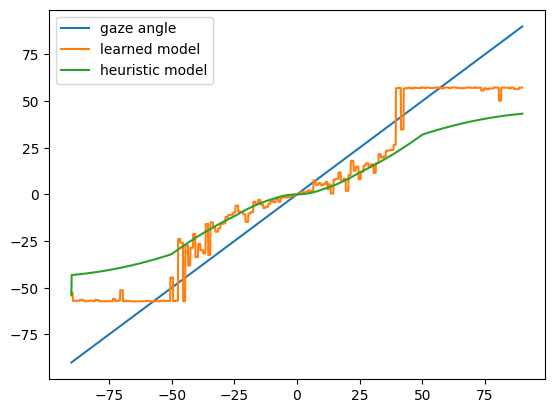

In [124]:
from prototypes.Jin2019.EyeHeadDecomposition import Heuristic_decomposition_azimuth, Heuristic_decomposition_elevation, GMM_Decomposition
azi_decomp = GMM_Decomposition.fromfile(
        "prototypes/Jin2019/model/head_eye_decomposition_azimuth_60_clusters_fixation/")
ele_decomp = GMM_Decomposition.fromfile(
        "prototypes/Jin2019/model/head_eye_decomposition_elevation_60_clusters_fixation/")
azi_decomp2 = Heuristic_decomposition_azimuth(1)
ele_decomp2 = Heuristic_decomposition_elevation()
elevations = np.arange(-900, 900)/10
prev_ele = elevations[0]
output_ele = []

for ele in elevations:
    ele_gaze, ele_head = azi_decomp.decompose(ele, prev_ele)
    prev_ele = ele
    output_ele.append(ele_head)
output_ele2 = []
prev_ele = elevations[0]
for ele in elevations:
    ele_gaze, ele_head = azi_decomp2.decompose(ele, 0.3)
    prev_ele = ele
    output_ele2.append(ele_head)
plt.plot(elevations, elevations, label="gaze angle")
plt.plot(elevations, output_ele, label="learned model")
plt.plot(elevations, output_ele2, label="heuristic model")
plt.legend()

### Check optimizion output

101 (101, 2)
(101, 2, 3)


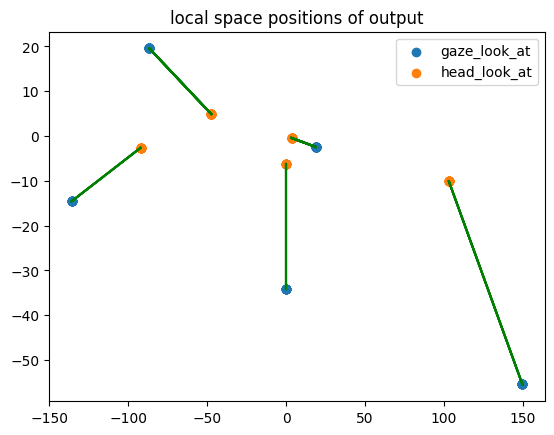

(101, 2, 2)


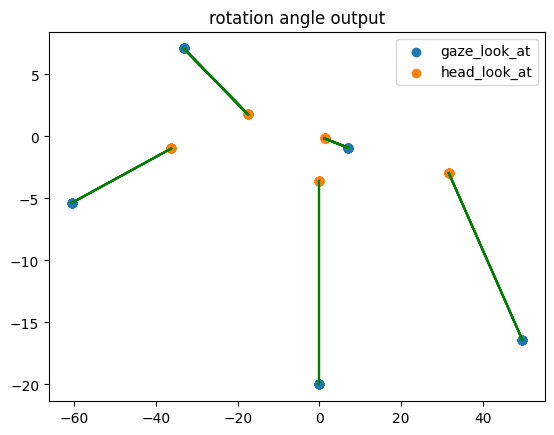

In [137]:
generator = SacccadeGenerator(output_times, output_target_positions, output_targets, internal_model)
# print(output_times, output_target_positions, output_targets)
ek, hk, micro_saccade = generator.compute()
pt1 = np.expand_dims(generator.target_gaze_intervals_pos, axis=1)
pt2 = np.expand_dims(generator.target_positions_head, axis=1)
lines = np.concatenate([pt1, pt2], axis=1)
print(lines.shape)
for i in range(0, 40):
    plt.plot(lines[i, :, 0], lines[i, :, 1], color="green", )
display_targetss(generator.target_gaze_intervals_pos, label="gaze_look_at")
display_targetss(generator.target_positions_head, label="head_look_at")
plt.legend()
plt.title("local space positions of output")
plt.show()


target_gaze_intervals_rot = rotation_angles_frome_positions(generator.target_gaze_intervals_pos)
target_positions_head_rot = rotation_angles_frome_positions(generator.target_positions_head)

pt1 = np.expand_dims(target_gaze_intervals_rot, axis=1)
pt2 = np.expand_dims(target_positions_head_rot, axis=1)
lines = np.concatenate([pt1, pt2], axis=1)
print(lines.shape)
for i in range(0, 40):
    plt.plot(lines[i, :, 0], lines[i, :, 1], color="green", )
display_targetss(target_gaze_intervals_rot, label="gaze_look_at")
display_targetss(target_positions_head_rot, label="head_look_at")
plt.legend()
plt.title("rotation angle output")
plt.show()




101 (101, 2)


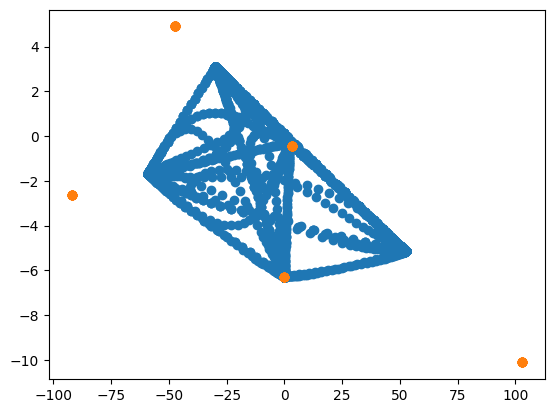

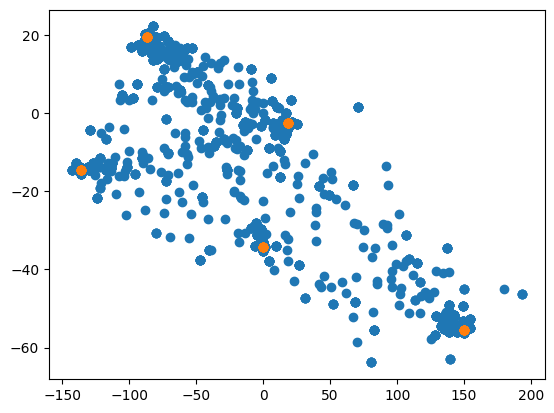

In [138]:
generator = SacccadeGenerator(output_times, output_target_positions, output_targets, internal_model)
# print(output_times, output_target_positions, output_targets)
ek, hk, micro_saccade = generator.compute()

display_targetss(generator.head_positions)
display_targetss(generator.target_positions_head, label="head_look_at")
plt.show()
display_targetss(generator.gaze_positions)
display_targetss(generator.target_gaze_intervals_pos, label="head_look_at")


In [51]:
generator = SacccadeGenerator(output_times, output_target_positions, output_targets, internal_model)
# print(output_times, output_target_positions, output_targets)
ek, hk, micro_saccade = generator.compute()

(1, 6070, 3)


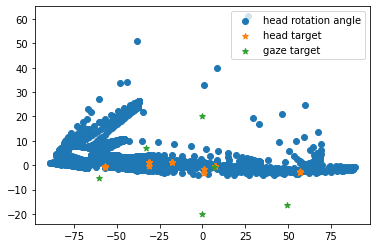

In [52]:
from Geometry_Util import rotation_angles_frome_positions
angles = []
for i in range(scene.get_all_positions().shape[0]):
    pos = scene.get_all_positions()[i]
    angle = rotation_angles_frome_positions(pos)
    angles.append(angle)
angles = np.array(angles)
arr_hk = np.array(hk)
head_targets = generator.target_positions_head
head_targets = np.array(head_targets)
head_targets_angle = rotation_angles_frome_positions(head_targets)
print(arr_hk.shape)
plt.scatter(arr_hk[0, :, 1], arr_hk[0, :, 2], label="head rotation angle")
plt.scatter(head_targets_angle[:, 0], head_targets_angle[:, 1], label="head target", marker="*")
plt.scatter(angles[:, 0], angles[:, 1], label="gaze target", marker="*")
plt.legend()

[-60.62078492  -5.366277  ]
[-33.17300902   7.09627413]
[ 49.65483209 -16.41357826]
[ 7.01615413 -0.9076499 ]
[  0. -20.]
[ 0. 20.]
